Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

In [2]:
###students have the following attributes and categories
#name First, Last
#sex M or F
#RUID 9-digit number
#date_of_birth year-month-day
#student_year Freshman-Senior
#student_school 
#accessibility_need 0 or 1
#low_income_status 0 or 1
#preferred_hall_ids list of ids
#preferred_residence_type
#is_single_preferred 0 or 1
#private_bathroom_preferred 0 or 1
#laundry_availibility 0 or 1
#preferred_price_range
#max_price
#roommate_preferences list of RUIDs
###

In [3]:
import urllib
import pandas as pd
import numpy as np
import random
import yaml
import networkx as nx

In [4]:
#the following helper functions are used for roommate pairing before room assignment 
#a pair can be made between a student i, j if they first have the same sex, grads and undergrads must be seperate
#and accessibility requirements

In [5]:
url = '../../shared/DormRooms/Data/datasetA_with_roommate_pref.csv'
student_df = pd.read_csv(url, index_col= False)
student_df
student_df['preferred_hall_ids'].unique()
student_df['compatible_roommate'] = [set() for _ in range(len(student_df))]
student_df['best_roommate'] = "None"
student_df['roommate_after_algorithm'] = None
student_df['assigned_to_room'] = 0
student_df['student_year'].unique()

array(['Sophomore', 'Freshman', 'Junior', 'Senior', 'Masters',
       'Doctorate', 'Postdoctoral studies'], dtype=object)

In [6]:
#return 1 if two students are the same sex; 0 otherwise 
def compare_sex(student1, student2): 
    if student1.sex == student2.sex: return 1 
    return 0

#returns 1 if both students are in the same level of schooling (both undergrad or both grad); 0 otherwise 
def compare_school_level(s1, s2): 
    undergrad_years = ["Freshman", "Sophomore", "Junior", "Senior"] 
    if s1.student_year in undergrad_years and s2.student_year in undergrad_years: return 1 
    if s2.student_year not in undergrad_years and s2.student_year not in undergrad_years: return 1 
    return 0

#returns 1 if both students are in the same school year; 0 otherwise 
def compare_school_year(s1, s2): 
    if s1.student_year == s2.student_year: return 1 
    return 0

#returns 1 if both students are in the same school; 0 otherwise 
def compare_school(s1, s2): 
    if s1.student_school == s2.student_school: return 1 
    return 0

#returns 1 if both students have the same accessibility_need; 0 otherwise 
def compare_accessibility(s1, s2): 
    return int(s1.accessibility_need == s2.accessibility_need)

#returns 1 if both students are the same low_income_status; 0 otherwise 
def compare_income_status(s1, s2): 
    return int(s1.low_income_status == s2.low_income_status)

#returns 1 if both students have the same preferred_residence_type; 0 otherwise 
def compare_residence_type(s1, s2): 
    return int(s1.preferred_residence_type == s2.preferred_residence_type)

#returns 1 if both students single_preferred status is the same; 0 otherwise 
def compare_single_preference(s1, s2): 
    return int(s1.is_single_preferred == s2.is_single_preferred)

#returns 1 if both students private bathroom preference is the same; 0 otherwise 
def compare_bathroom_preference(s1, s2): 
    return int(s1.is_private_bathroom_preferred == s2.is_private_bathroom_preferred)

#returns 1 if both students laundry availibility is the same; 0 otherwise 
def compare_laundry_availibility(s1, s2): 
    return int(s1.laundry_availibility == s2.laundry_availibility)

#returns 1 if both students have the same preferred price range; 0 otherwise 
def compare_price_range(s1, s2): 
    return int(s1.preferred_price_range == s2.preferred_price_range)

#returns 1 if both students have the same
def compare_max_price(s1, s2):
    return int(s1.max_price == s2.max_price)

#returns 1 if both students are in eachother's preferred roommate list; 0 otherwise
def compare_roommate_preference(s1, s2):
    if s1.roommate_preferences == '[]' or s2.roommate_preferences == '[]': return 0
    s1_pref = [int(x) for x in s1.roommate_preferences.strip('').strip('[]').strip(' ').split(',')]
    s2_pref = [int(x) for x in s2.roommate_preferences.strip('').strip('[]').strip(' ').split(',')]
    for id in s1_pref:
        if id in s2_pref:
            return 1
    return 0

#returns 1 if both students share a preferred hall id; 0 otherwise; and the set of hall ids in common
def has_common_hall_pref(s1, s2):
    if s1.preferred_hall_ids == '[]' or s2.preferred_hall_ids == '[]': return 0
    s1_pref = s1.preferred_hall_ids.strip('').strip('[]').replace(' ', ',').split(',')
    s2_pref = s2.preferred_hall_ids.strip('').strip('[]').replace(' ', ',').split(',')
    in_common = set()
    for hall in s1_pref:
        if hall in s2_pref:
            in_common.add(hall)
    if not in_common:
        return 0
    else: 
        return (1, in_common)

#returns 1 if two students form a valid pair
def is_compatible_pair(s1, s2):
    accessibility_compatibility = compare_accessibility(s1, s2)
    school_level_compatibility = compare_school_level(s1, s2) #can be changed to compare_school_year for more precise matching
    sex_compatibility = compare_sex(s1, s2)
    roommate_compatibility = compare_roommate_preference(s1, s2)
    school_year_compatibility = compare_school_year(s1, s2)
    if accessibility_compatibility and school_level_compatibility and sex_compatibility and roommate_compatibility and school_year_compatibility:
        return 1
    else:
        return 0

#5 points for roommates who want to be together, 3 points preferred price ranges match, 1 point preferred amenities match
def student_pair_score(s1, s2):
    score = 0
    if compare_roommate_preference(s1, s2):
        score += 5
    if compare_price_range(s1, s2):
        score += 3
    if compare_bathroom_preference(s1, s2):
        score += 0.5
    if compare_laundry_availibility(s1, s2):
        score += 0.5
    return score

In [7]:
#testing for helper functions (can be removed before submission)
s1 = student_df.iloc[0]
s2 = student_df.iloc[1]
print(compare_sex(s1, s2))
print(compare_school_level(s1, s2))
print(compare_school_year(s1, s2))
print(compare_school(s1, s2))
print(compare_accessibility(s1, s2))
print(compare_income_status(s1, s2))
print(compare_residence_type(s1, s2))
print(compare_single_preference(s1, s2))
print(compare_bathroom_preference(s1, s2))
print(compare_laundry_availibility(s1, s2))
print(compare_price_range(s1, s2))
print(compare_max_price(s1, s2))
print(compare_roommate_preference(s1, s2))
has_common_hall_pref(s1, s2)
print('\n')
print(is_compatible_pair(s1, s2))
print(student_pair_score(s1, s2))

1
1
1
0
0
1
1
1
1
1
0
0
0


0
1.0


In [8]:
#will add to student_df a field that is a set of all possible compatible pairs
#will need to add a field to room_data for number of students currently in room

In [9]:
#creating new column in student dataframe for possible student pairs will be a tuple (RUID, pair_score)
print(len(student_df))

def make_matches():
    for i in range(len(student_df) - 1):
        matches = set()
        s1 = student_df.iloc[i]
        curr_best_match_score = 0.0
        curr_best_match = None
        for j in range(i + 1, len(student_df)):
            s2 = student_df.iloc[j]
            if is_compatible_pair(s1, s2):
                score = student_pair_score(s1, s2)
                matches.add((s2.RUID, score))
                if score > curr_best_match_score:
                    curr_best_match_score = score
                    curr_best_match = (s2.RUID, score)
                elif score == curr_best_match_score:
                    #implement some sort of tie breaking
                    #print("TIE")
                    tie = 0
        student_df.at[i, 'compatible_roommate'] = matches
        student_df.at[i, 'best_roommate'] = curr_best_match
        if i % 100 == 0: print(f"Best Match for {i} = {curr_best_match}")
        
#make matches and find everyone's highest scoring match
make_matches()
s1 = student_df.iloc[0]
#print(s1.best_roommate)
#print(s1.compatible_roommate)

5330
Best Match for 0 = None
Best Match for 100 = None
Best Match for 200 = None
Best Match for 300 = None
Best Match for 400 = None
Best Match for 500 = None
Best Match for 600 = None
Best Match for 700 = None
Best Match for 800 = None
Best Match for 900 = None
Best Match for 1000 = None
Best Match for 1100 = None
Best Match for 1200 = None
Best Match for 1300 = (725472783, 6.0)
Best Match for 1400 = None
Best Match for 1500 = None
Best Match for 1600 = None
Best Match for 1700 = None
Best Match for 1800 = None
Best Match for 1900 = None
Best Match for 2000 = None
Best Match for 2100 = None
Best Match for 2200 = None
Best Match for 2300 = None
Best Match for 2400 = None
Best Match for 2500 = None
Best Match for 2600 = None
Best Match for 2700 = None
Best Match for 2800 = None
Best Match for 2900 = None
Best Match for 3000 = None
Best Match for 3100 = None
Best Match for 3200 = None
Best Match for 3300 = None
Best Match for 3400 = None
Best Match for 3500 = None
Best Match for 3600 = N

In [10]:
s1 = student_df.loc[0]
print(s1.compatible_roommate)

set()


In [11]:
#build graph of possible student pairs and run max_weight_algo
def find_maximum_weighted_pairs():
    G = nx.Graph()
    for _, row in student_df.iterrows():
        RUID = row['RUID']
        for roommate_ruid, score in sorted(row['compatible_roommate'], key=lambda x: x[1], reverse=True)[:50]:
            G.add_edge(RUID, roommate_ruid, weight=score)
    max_pairs = nx.algorithms.matching.max_weight_matching(G, maxcardinality=True)
    pairs_dict = {student_a: student_b for student_a, student_b in max_pairs}
    pairs_dict.update({student_b: student_a for student_a, student_b in max_pairs})
    student_df['roommate_after_algorithm'] = student_df['RUID'].map(pairs_dict)
    #print(pairs_dict)
    #print(len(pairs_dict))
    return pairs_dict

roommate_pairs = find_maximum_weighted_pairs()
s1 = student_df.iloc[0]
print(s1.roommate_after_algorithm)

nan


In [12]:
s1 = student_df.iloc[0]
print(s1.roommate_after_algorithm)

nan


In [13]:
#might need to change roommate matching to be only viable if people are in same year or only for people who want to be together
#helper functions for the actual room matching

#get the dataframe for the rooms
room_df = pd.read_csv('../../shared/DormRooms/Data/final_room_data.csv')
room_df['current_occupancy'] = 0
undergrad_years = ["Freshman", "Sophomore", "Junior", "Senior"]
graduate_years = ["Masters", "Doctorate", "Postdoctoral studies"]

#returns 2 if the student and room are both accessible, 1 if student is not accessible and room is, 0 if the student is accessible and the room is
def check_room_accessibility(student, room):
    if student.accessibility_need == 1 and room.has_accessibility_ramps == 1:
        return 2
    elif student.accessibility_need == 0 and room.has_accessibility_ramps == 1:
        return 1
    return 0

#returns 1 if the hall is in the student's preferred hall list; 0 otherwise
def student_preferred_hall(student, room):
    if student.preferred_hall_ids == '[]': return 0
    student_pref = s1.preferred_hall_ids.strip('').strip('[]').replace(' ', ',').split(',')
    if room.hall_id in student_pref:
        return 1
    return 0

#returns 1 if room has private bathroom; 0 otherwise
def private_bathroom_match(student, room):
    if student.is_private_bathroom_preferred == 1 and room.has_private_bathroom == 1:
        return 2
    if student.is_private_bathroom_preferred == 0 and room.has_private_bathroom == 1:
        return 1
    if studnet.is_private_bathroom_preferred == 0 and room.has_private_bathroom == 0:
        return 2
    return 0

#returns 1 if the student level matches the hall level
def hall_level_match(student, room):
    year = student.student_year
    contract = room.room_contract_type
    if year == 'Freshman' or year == 'Sophomore' or year == 'Junior' or year == 'Senior':
        if contract == 'Undergraduate Academic Year (Two Semesters)':
            return 1
        return 0
    elif contract == 'Graduate Full Calendar Year - 12 Month Contracts (Two semesters and all breaks)':
        return 1
    return 0

#returns the list of student preferred halls
def get_student_preferred_halls(student):
    if student.preferred_hall_ids == '[]': return 0
    student_pref = student.preferred_hall_ids.strip('').strip('[]').replace(' ', ',').replace("'", '').replace('"', '').split(',')
    return student_pref

#returns 1 if the students max price is greater than the price of the room; 0 otherwise
def can_student_afford(student, room):
    if student.max_price >= room.price:
        return 1
    return 0

#returns 1 if the room price is in the students preferred price range; 0 otherwise
def in_preferred_price_range(student, room):
    try:
        price_range = str(student.preferred_price_range).replace('-', ' ').split(' ')
        low_price = price_range[0]
        high_price = price_range[1]
        if int(high_price) >= int(room.price):
            #print("IN RANGE")
            return 1
        #print(price_range)
    except Exception:
        return 0
    
    return 0

#returns 1 if student is in a pair, 0 otherwise
def is_in_pair(student):
    if not pd.isna(student.roommate_after_algorithm):
        return 1
    return 0

#returns the student_room score: (1 point per matching ammenity, 5 points if preferred hall match (1 additional point for distance from the end), 3 points if in preferred price range, 2 points if single preferred and room is a single
def get_student_room_score(student, room):
    score = 0
    if in_preferred_price_range(student, room):
        score += 3
    if not is_in_pair(student) and student.is_single_preferred == 1 and room.max_room_occupancy == 1:
        score += 2
    if student.laundry_availibility == 1 and room.has_laundry == 1:
        score += 1
    if student.is_private_bathroom_preferred and room.has_private_bathroom:
        score += 1
    hall_pref = get_student_preferred_halls(student)
    #print(hall_pref)
    additional_score = len(hall_pref)
    for i in range(len(hall_pref)):
        #print(hall_pref[i])
        if str(hall_pref[i]) == str(room.hall_id):
            #print("FOUND")
            score += 8
            break
            additional_score -= 1
    score += additional_score
    #if room.hall_id in hall_pref:
        #score += 8
        #additional_score = len(hall_pref)
        #for hall in hall_pref:
            #if hall == room.hall_id:
                #break
            #additional_score -= 1
        #score += additional_score

    return score

#returns 1 if the student(s) can be assigned to the room; 0 otherwise 
def is_room_viable(student, room):
    if student.max_price < room.price:
        return 0
    if student.accessibility_need == 1 and room.has_accessibility_ramps == 0:
        return 0
    return 1
    
#returns the order of the students room application


#returns 1 if a student is undergrad; 0 otherwise
def get_level(year):
    if year in undergrad_years:
        return 1
    return 0

#returns 0 if a room is graduate_level or 1 if undergraduate
def get_room_level(room):
    if room.room_contract_type == 'Undergraduate Academic Year (Two Semesters)':
        return 1
    return 0

def sort_students(student_dataframe):
    grad_order = {"Postdoctoral studies": 1, "Doctorate": 2, "Masters": 3}
    undergrad_order = {"Senior": 1, "Junior": 2, "Sophomore": 3, "Freshman": 4}
    return grad_order.get(year, undergrad_order.get(year, 99))

#get the rooms a student can apply to
def get_student_rooms(student, room_df):
    student_level = get_level(student.student_year)
    rooms = room_df[
        room_df.apply(
            lambda room: (
                get_room_level(room) == student_level and room['has_accessibility_ramps'] >= student['accessibility_need']
            ),
            axis=1
        )
    ]
    

    viable_rooms = []
    for _, room in rooms.iterrows():
        if is_room_viable(student, room) == 1:
            viable_rooms.append((room['room_id'], get_student_room_score(student, room)))

    sorted_viable_rooms = sorted(viable_rooms, key=lambda x: x[1], reverse=True)
    return sorted_viable_rooms

#get the room from the dataframe
def get_room_by_id(room_id, room_df):
    return room_df.loc[room_df['room_id'] == room_id].iloc[0]
         
        

In [14]:
#room assignment functions
#room assignment will go in order of student level Senior -> Freshman | Postdoc -> Masters Grad students go first Disabled go first in school type

In [15]:
s1 = student_df.loc[5]
print(is_in_pair(s1))

if 'possible_rooms' not in student_df.columns:
    student_df['possible_rooms'] = None
#s1.possible_rooms = get_student_rooms(s1, room_df)

#print(s1.possible_rooms)
#for room_id in s1.possible_rooms:
    #room = get_room_by_id(room_id, room_df)
    #print(get_student_room_score(s1, room))
    #print(room_id)

#gets all the rooms a student can apply to
for i in range(len(student_df)):
    student = student_df.iloc[i]
    rooms = get_student_rooms(student, room_df)
    student_df.at[i, 'possible_rooms'] = rooms
    if i % 1000 == 0 or i == 5329:
        print(f"Done with {student}, {i}")

#ranks all student rooms by score

0
Done with name                                  Jennifer Simmons
sex                                                  F
RUID                                         977522906
date_of_birth                               2000-10-10
student_year                                 Sophomore
student_school                   School of Engineering
accessibility_need                                   1
low_income_status                                    0
preferred_hall_ids                    ['WS' 'BS' 'RA']
preferred_residence_type                     Apartment
is_single_preferred                                  1
is_private_bathroom_preferred                        1
laundry_availibility                                 1
preferred_price_range                       8000-11000
max_price                                        12000
roommate_preferences                                []
compatible_roommate                                 {}
best_roommate                                     Non

In [16]:
s = student_df.iloc[0]
#print(s.possible_rooms)
ex_room = room_df.iloc[722]
print(get_student_room_score(s, ex_room))
#print(s.preferred_hall_ids)
#print(ex_room.hall_id)

8


In [17]:
def room_lookup(room_df):
    return {
        r['room_id']: r
        for _, r in room_df.iterrows()
    }

def deferred_acceptance_algorithm(student_df, room_df):
    student_df['is_assigned'] = False
    room_df_copy = room_df.copy()
    room_df['current_occupancy'] = 0

    room_lookup_table = room_lookup(room_df_copy)
    room_scores = {
        s['RUID']: s['possible_rooms']
        for _, s in student_df.iterrows()
    }

    room_assignments = []
    unassigned_students = set(student_df['RUID'])

    student_df = student_df.sort_values(
        by=['accessibility_need', 'student_year'],
        ascending=[False, True],
        key=lambda s: s.map({
            'Postdoctoral Studies': 1, 'Doctorate': 2, 'Masters': 3,
            'Senior': 4, 'Junior': 5, 'Sophomore': 6, 'Freshman': 7
        })
    )

    student_df['pair_id'] = student_df.apply(
        lambda s: min(s['RUID'], s['roommate_after_algorithm'])
        if pd.notna(s['roommate_after_algorithm']) else s['RUID'],
        axis=1
    )

    proposals_pending = True
    round_number = 0

    while proposals_pending:
        round_number += 1
        proposals_pending = False
        room_proposals = []

        for pair_id, group in student_df.groupby('pair_id'):
            pair_members = group['RUID'].tolist()

            if not any(uid in unassigned_students for uid in pair_members):
                continue

            if all(student_df.loc[student_df['RUID'] == uid, 'is_assigned'].iloc[0] for uid in pair_members):
                continue
            
            if len(pair_members) == 2:
                s1, s2 = [group.iloc[0], group.iloc[1]]

                if s1['RUID'] not in room_scores or s2['RUID'] not in room_scores:
                    continue

                if s1.is_assigned or s2.is_assigned:
                    continue

                rooms1 = [r for r, _ in room_scores[s1['RUID']]]
                rooms2 = [r for r, _ in room_scores[s2['RUID']]]
                viable = list(set(rooms1) & set(rooms2))
                if not viable:
                    continue

                target_room = viable[0]
                room_proposals.append((pair_id, target_room, [student['RUID']]))
            else:
                student = group.iloc[0]
                if student.is_assigned:
                    continue
                possible = room_scores.get(student['RUID'], [])
                if not possible:
                    continue
                target_room = possible[0][0]
                room_proposals.append((pair_id, target_room, [student['RUID']]))
        proposal_df = pd.DataFrame(room_proposals, columns=['pair_id', 'room_id', 'members'])
        for room_id, sub in proposal_df.groupby('room_id'):
            room_info = room_lookup_table[room_id]
            room_applicants = []

            for _, row in sub.iterrows():
                members = row['members']
                pair_score = sum(
                    next((score for rid, score in room_scores[m] if rid == room_id), 0) for m in members
                )
                room_applicants.append((row['pair_id'], members, pair_score))

            room_applicants.sort(key=lambda x: x[2], reverse=True)

            for pair_id, members, score in room_applicants:
                space_needed = len(members)
                space_remaining = room_info['max_room_occupancy'] - room_info['current_occupancy']
                if space_remaining >= space_needed:
                    for uid in members:
                        room_assignments.append((uid, room_id))
                        if uid in unassigned_students:
                            unassigned_students.remove(uid)
                    room_info['current_occupancy'] += space_needed
                else:
                    proposals_pending = True
                    for uid in members:
                        room_scores[uid] = [(rid, score) for rid, score in room_scores[uid] if rid != room_id]
        if round_number % 50 == 0 or round_number == 1:
            print(f"Round {round_number} is complete :: {len(room_assignments)} assigned {len(unassigned_students)} unassigned")

        if round_number > 500:
            break
    return pd.DataFrame(room_assignments, columns=['student_RUID', 'assigned_rooms'])

assigned_df = deferred_acceptance_algorithm(student_df, room_df)




Round 1 is complete :: 50 assigned 5283 unassigned
Round 50 is complete :: 1882 assigned 3451 unassigned
Round 100 is complete :: 3009 assigned 2324 unassigned
Round 150 is complete :: 3606 assigned 1727 unassigned
Round 200 is complete :: 4064 assigned 1269 unassigned
Round 250 is complete :: 4412 assigned 921 unassigned
Round 300 is complete :: 4462 assigned 871 unassigned
Round 350 is complete :: 4577 assigned 756 unassigned
Round 400 is complete :: 4577 assigned 756 unassigned
Round 450 is complete :: 4578 assigned 755 unassigned
Round 500 is complete :: 4578 assigned 755 unassigned


In [18]:
def assign_remaining_students(student_df, room_df, assigned_df):
    assigned_ruids = set(assigned_df['student_RUID'])
    unassigned_students = student_df[~student_df['RUID'].isin(assigned_ruids)]

    unassigned_students = pd.DataFrame({
        'student_RUID': unassigned_students['RUID'],
        'assigned_rooms': [float('nan')] * len(unassigned_students)
    })

    combined_df = pd.concat([assigned_df, unassigned_students], ignore_index=True)

    print(f"Added {len(unassigned_students)} unassigned students with NaN room values.")
    return combined_df

final_df = assign_remaining_students(student_df, room_df, assigned_df)


Added 755 unassigned students with NaN room values.


In [19]:
final_df = final_df[~final_df.duplicated(subset='student_RUID', keep='first')].reset_index(drop=True)

def check_room_algo():
    duplicates = final_df['student_RUID'].value_counts()
    students = duplicates[duplicates > 1]

    if students.empty:
        print("No duplicate students")
    else:
        #print("UH OH")
        print(students)
        for ruid, count in students.items():
            rooms = assigned_df.loc[final_df['student_RUID'] == ruid, 'assigned_rooms'].tolist()

print(check_room_algo())

def print_df():
    print(len(final_df))
    for i in range(len(final_df)):
        break

print_df()
print("done")

No duplicate students
None
5330
done


In [64]:
#evaluation metrics and graph 
def get_total_student_amenities(room):
    total = 0
    if room.is_aircooled:
        total += 1
    if room.has_vending_machine:
        total += 1
    if room.has_main_lounge:
        total += 1
    if room.has_floor_lounge:
        total += 1
    if room.has_tv_in_building:
        total += 1
    if room.has_recreational_activities:
        total += 1
    if room.has_wardrobe:
        total += 1
    return total

final_df['in_preferred_hall'] = 0
final_df['in_preferred_res'] = 0
final_df['laundry_met'] = 0
final_df['bathroom_met'] = 0
final_df['in_price_range'] = 0

total_in_preferred_hall = 0
total_in_preferred_hall_post_doc = 0
total_in_preferred_hall_doctorate = 0
total_in_preferred_hall_masters = 0
total_in_preferred_hall_senior = 0
total_in_preferred_hall_junior = 0
total_in_preferred_hall_sophomore = 0
total_in_preferred_hall_freshman = 0
total_in_preferred_res_type = 0
total_in_preferred_res_post_doc = 0
total_in_preferred_res_doctorate = 0
total_in_preferred_res_masters = 0
total_in_preferred_res_senior = 0
total_in_preferred_res_junior = 0
total_in_preferred_res_sophomore = 0
total_in_preferred_res_freshman = 0
total_want_has_laundry = 0
total_want_has_laundry_post_doc = 0
total_want_has_laundry_doctorate = 0
total_want_has_laundry_masters = 0
total_want_has_laundry_senior = 0
total_want_has_laundry_junior = 0
total_want_has_laundry_sophomore = 0
total_want_has_laundry_freshman = 0
total_want_has_bathroom = 0
total_want_has_bathroom_post_doc = 0
total_want_has_bathroom_doctorate = 0
total_want_has_bathroom_masters = 0
total_want_has_bathroom_senior = 0
total_want_has_bathroom_junior = 0
total_want_has_bathroom_sophomore = 0
total_want_has_bathroom_freshman = 0
total_in_preferred_price = 0
total_in_preferred_price_post_doc = 0
total_in_preferred_price_doctorate = 0
total_in_preferred_price_masters = 0
total_in_preferred_price_senior = 0
total_in_preferred_price_junior = 0
total_in_preferred_price_sophomore = 0
total_in_preferred_price_freshman = 0
total_student_scores = 0
total_students = 0
total_post_doc = 0
total_phd = 0
total_masters = 0
total_senior = 0
total_junior = 0
total_sophomore = 0
total_freshman = 0
total_post_doc_score = 0
total_doctorate_score = 0
total_masters_score = 0
total_senior_score = 0
total_junior_score = 0
total_sophomore_score = 0
total_freshman_score = 0
total_amen_post_doc = 0
total_amen_phd = 0
total_amen_masters = 0
total_amen_senior = 0
total_amen_junior = 0
total_amen_sophomore = 0
total_amen_freshman = 0
total_amen = 0
total_amen_avg = 0
total_amen_avg_post_doc = 0
total_amen_avg_phd = 0
total_amen_avg_masters = 0
total_amen_avg_senior = 0
total_amen_avg_junior = 0
total_amen_avg_sophomore = 0
total_amen_avg_freshman = 0
avg_cost = 0
avg_cost_post_doc = 0
avg_cost_phd = 0
avg_cost_masters = 0
avg_cost_senior = 0
avg_cost_junior = 0
avg_cost_sophomore = 0
avg_cost_freshman = 0
#print(final_df.iloc[0])
for i in range(len(final_df)):
    RUID = final_df.loc[i, 'student_RUID']
    student = student_df.loc[student_df['RUID'] == RUID].iloc[0]
    student_index = student.index[0]
    student_year = student.student_year
    if student_year == 'Postdoctoral studies':
        total_post_doc += 1
    elif student_year == 'Doctorate':
        total_phd += 1
    elif student_year == 'Masters':
        total_masters += 1
    elif student_year == 'Senior':
        total_senior += 1
    elif student_year == 'Junior':
        total_junior += 1
    elif student_year == 'Sophomore':
        total_sophomore += 1
    elif student_year == 'Freshman':
        total_freshman += 1
    room_id = final_df.loc[i, 'assigned_rooms']
    if pd.notna(room_id):    
        total_students += 1
        room = room_df.loc[room_df['room_id'] == room_id].iloc[0]
        total_student_scores += get_student_room_score(student, room)
        total_amen_avg = get_total_student_amenities(room)
        if student_year == 'Postdoctoral studies':
            total_post_doc_score += get_student_room_score(student, room)
            total_amen_avg_post_doc = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_post_doc += 1
        elif student_year == 'Doctorate':
            total_doctorate_score += get_student_room_score(student, room)
            total_amen_avg_phd = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_phd += 1
        elif student_year == 'Masters':
            total_masters_score += get_student_room_score(student, room)
            total_amen_avg_masters = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_masters += 1
        elif student_year == 'Senior':
            total_senior_score += get_student_room_score(student, room)
            total_amen_avg_senior = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_senior += 1
        elif student_year == 'Junior':
            total_junior_score += get_student_room_score(student, room)
            total_amen_avg_junior = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_junior += 1
        elif student_year == 'Sophomore':
            total_sophomore_score += get_student_room_score(student, room)
            total_amen_avg_sophomore = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_sophomore += 1
        elif student_year == 'Freshman':
            total_freshman_score += get_student_room_score(student, room)
            total_amen_avg_freshman = get_total_student_amenities(room)
            if get_total_student_amenities(room) >= 3:
                total_amen += 1
                total_amen_freshman += 1
        #print(room)
        #print(student)
        halls = get_student_preferred_halls(student)
        for i in range(len(halls)):
            if str(halls[i]) == str(room.hall_id):
                total_in_preferred_hall += 1
                final_df.at[i, 'in_preferred_hall'] = 1
                if student_year == 'Postdoctoral studies':
                    total_in_preferred_hall_post_doc += 1
                elif student_year == 'Doctorate':
                    total_in_preferred_hall_doctorate += 1
                elif student_year == 'Masters':
                    total_in_preferred_hall_masters += 1
                elif student_year == 'Senior':
                    total_in_preferred_hall_senior += 1
                elif student_year == 'Junior':
                    total_in_preferred_hall_junior += 1
                elif student_year == 'Sophomore':
                    total_in_preferred_hall_sophomore += 1
                elif student_year == 'Freshman':
                    total_in_preferred_hall_freshman += 1
                #print("HALL FOUND")
        #print(final_df.iloc[i])
        if student.preferred_residence_type == room.residence_type:
            total_in_preferred_res_type += 1
            final_df.at[i, 'in_preferred_res'] = 1
            if student_year == 'Postdoctoral studies':
                total_in_preferred_res_post_doc += 1
            elif student_year == 'Doctorate':
                total_in_preferred_res_doctorate += 1
            elif student_year == 'Masters':
                total_in_preferred_res_masters += 1
            elif student_year == 'Senior':
                total_in_preferred_res_senior += 1
            elif student_year == 'Junior':
                total_in_preferred_res_junior += 1
            elif student_year == 'Sophomore':
                total_in_preferred_res_sophomore += 1
            elif student_year == 'Freshman':
                total_in_preferred_res_freshman += 1
        if (student.laundry_availibility == 1 and room.has_laundry) or (student.laundry_availibility == 0 and not room.has_laundry):
            total_want_has_laundry += 1
            final_df.at[i, 'laundry_met'] = 1
            if student_year == 'Postdoctoral studies':
                total_want_has_laundry_post_doc += 1
            elif student_year == 'Doctorate':
                total_want_has_laundry_doctorate += 1
            elif student_year == 'Masters':
                total_want_has_laundry_masters += 1
            elif student_year == 'Senior':
                total_want_has_laundry_senior += 1
            elif student_year == 'Junior':
                total_want_has_laundry_junior += 1
            elif student_year == 'Sophomore':
                total_want_has_laundry_sophomore += 1
            elif student_year == 'Freshman':
                total_want_has_laundry_freshman += 1
            #print("ALL GOOD")
        if (student.is_private_bathroom_preferred and room.has_private_bathroom) or (student.is_private_bathroom_preferred == 0 and room.has_private_bathroom) or (student.is_private_bathroom_preferred == 0 and not room.has_private_bathroom):
            total_want_has_bathroom += 1
            final_df.at[i, 'bathroom_met'] = 1
            if student_year == 'Postdoctoral studies':
                total_want_has_bathroom_post_doc += 1
            elif student_year == 'Doctorate':
                total_want_has_bathroom_doctorate += 1
            elif student_year == 'Masters':
                total_want_has_bathroom_masters += 1
            elif student_year == 'Senior':
                total_want_has_bathroom_senior += 1
            elif student_year == 'Junior':
                total_want_has_bathroom_junior += 1
            elif student_year == 'Sophomore':
                total_want_has_bathroom_sophomore += 1
            elif student_year == 'Freshman':
                total_want_has_bathroom_freshman += 1
            #print("HAS TOILET")
        if in_preferred_price_range(student, room):
            total_in_preferred_price += 1
            final_df.at[i, 'in_price_range']
            if student_year == 'Postdoctoral studies':
                total_in_preferred_price_post_doc += 1
            elif student_year == 'Doctorate':
                total_in_preferred_price_doctorate += 1
            elif student_year == 'Masters':
                total_in_preferred_price_masters += 1
            elif student_year == 'Senior':
                total_in_preferred_price_senior += 1
            elif student_year == 'Junior':
                total_in_preferred_price_junior += 1
            elif student_year == 'Sophomore':
                total_in_preferred_price_sophomore += 1
            elif student_year == 'Freshman':
                total_in_preferred_price_freshman += 1
            #print("IN RANGEEEE")
print(f"The total number of students who are assigned to a room within a preferred hall: {total_in_preferred_hall}")
print(f"The percentage of students in a preferred hall: {total_in_preferred_hall/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_in_preferred_hall_post_doc} : {total_in_preferred_hall_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_in_preferred_hall_doctorate} : %{total_in_preferred_hall_doctorate/total_phd * 100}\n\tMasters: {total_in_preferred_hall_masters} : %{total_in_preferred_hall_masters/total_masters * 100}\n\tSenior: {total_in_preferred_hall_senior} : %{total_in_preferred_hall_senior/total_senior * 100}\n\tJunior: {total_in_preferred_hall_junior} : %{total_in_preferred_hall_junior/total_junior * 100}\n\tSophomore: {total_in_preferred_hall_sophomore} : %{total_in_preferred_hall_sophomore/total_sophomore * 100}\n\tFreshman: {total_in_preferred_hall_freshman} : %{total_in_preferred_hall_freshman/total_freshman * 100}")

print()
print(f"The total number of students who are assigned to a room that is their preferred residence type: {total_in_preferred_res_type}")
print(f"The percentage of students with preferred residence type: {total_in_preferred_res_type/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_in_preferred_res_post_doc} : {total_in_preferred_res_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_in_preferred_res_doctorate} : %{total_in_preferred_res_doctorate/total_phd * 100}\n\tMasters: {total_in_preferred_res_masters} : %{total_in_preferred_res_masters/total_masters * 100}\n\tSenior: {total_in_preferred_res_senior} : %{total_in_preferred_res_senior/total_senior * 100}\n\tJunior: {total_in_preferred_res_junior} : %{total_in_preferred_res_junior/total_junior * 100}\n\tSophomore: {total_in_preferred_res_sophomore} : %{total_in_preferred_res_sophomore/total_sophomore * 100}\n\tFreshman: {total_in_preferred_res_freshman} : %{total_in_preferred_res_freshman/total_freshman * 100}")

print()
print(f"The total number of students whose laundry availibility was met: {total_want_has_laundry}")
print(f"The percentage of students whose laundry availibility was met: {total_want_has_laundry/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_want_has_laundry_post_doc} : {total_want_has_laundry_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_want_has_laundry_doctorate} : %{total_want_has_laundry_doctorate/total_phd * 100}\n\tMasters: {total_want_has_laundry_masters} : %{total_want_has_laundry_masters/total_masters * 100}\n\tSenior: {total_want_has_laundry_senior} : %{total_want_has_laundry_senior/total_senior * 100}\n\tJunior: {total_want_has_laundry_junior} : %{total_want_has_laundry_junior/total_junior * 100}\n\tSophomore: {total_want_has_laundry_sophomore} : %{total_want_has_laundry_sophomore/total_sophomore * 100}\n\tFreshman: {total_want_has_laundry_freshman} : %{total_want_has_laundry_freshman/total_freshman * 100}")

print()
print(f"The total number of students whose private bathroom desire was met: {total_want_has_bathroom}")
print(f"The percentage of students whose private bathroom desire was met: {total_want_has_bathroom/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_want_has_bathroom_post_doc} : {total_want_has_bathroom_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_want_has_bathroom_doctorate} : %{total_want_has_bathroom_doctorate/total_phd * 100}\n\tMasters: {total_want_has_bathroom_masters} : %{total_want_has_bathroom_masters/total_masters * 100}\n\tSenior: {total_want_has_bathroom_senior} : %{total_want_has_bathroom_senior/total_senior * 100}\n\tJunior: {total_want_has_bathroom_junior} : %{total_want_has_bathroom_junior/total_junior * 100}\n\tSophomore: {total_want_has_bathroom_sophomore} : %{total_want_has_bathroom_sophomore/total_sophomore * 100}\n\tFreshman: {total_want_has_bathroom_freshman} : %{total_want_has_bathroom_freshman/total_freshman * 100}")

print()
print(f"The total number of students whose room price is in their preferred price range: {total_in_preferred_price}")
print(f"The percentage of students whose room price is in their preferred price range: {total_in_preferred_price/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_in_preferred_price_post_doc} : {total_in_preferred_price_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_in_preferred_price_doctorate} : %{total_in_preferred_price_doctorate/total_phd * 100}\n\tMasters: {total_in_preferred_price_masters} : %{total_in_preferred_price_masters/total_masters * 100}\n\tSenior: {total_in_preferred_price_senior} : %{total_in_preferred_price_senior/total_senior * 100}\n\tJunior: {total_in_preferred_price_junior} : %{total_in_preferred_price_junior/total_junior * 100}\n\tSophomore: {total_in_preferred_price_sophomore} : %{total_in_preferred_price_sophomore/total_sophomore * 100}\n\tFreshman: {total_in_preferred_price_freshman} : %{total_in_preferred_price_freshman/total_freshman * 100}")

print()
print(f"The total number of students who have at least 3 amenities: {total_amen}")
print(f"The percentage of students who have at least 3 amenities: {total_amen/len(final_df) * 100}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_amen_post_doc} : {total_amen_post_doc/total_post_doc * 100}%\n\tDoctorate: {total_amen_phd} : %{total_amen_phd/total_phd * 100}\n\tMasters: {total_amen_masters} : %{total_amen_masters/total_masters * 100}\n\tSenior: {total_amen_senior} : %{total_amen_senior/total_senior * 100}\n\tJunior: {total_amen_junior} : %{total_amen_junior/total_junior * 100}\n\tSophomore: {total_amen_sophomore} : %{total_amen_sophomore/total_sophomore * 100}\n\tFreshman: {total_amen_freshman} : %{total_amen_freshman/total_freshman * 100}")

print()
print(f"The average student-room score (see get_student_room_score() method for details): {total_student_scores/total_students}")
print(f"Broken down by student level:\n\tPostdoctoral: {total_post_doc_score/total_post_doc}\n\tDoctorate: {total_doctorate_score/total_phd}\n\tMasters: {total_masters_score/total_masters}\n\tSenior: {total_senior_score/total_senior}\n\tJunior: {total_junior_score/total_junior}\n\tSophomore: {total_sophomore_score/total_sophomore}\n\tFreshman: {total_freshman_score/total_freshman}")


The total number of students who are assigned to a room within a preferred hall: 2790
The percentage of students in a preferred hall: 52.34521575984991
Broken down by student level:
	Postdoctoral: 55 : 91.66666666666666%
	Doctorate: 157 : %67.67241379310344
	Masters: 194 : %66.43835616438356
	Senior: 256 : %55.53145336225597
	Junior: 514 : %53.541666666666664
	Sophomore: 711 : %50.822015725518234
	Freshman: 903 : %46.88473520249221

The total number of students who are assigned to a room that is their preferred residence type: 1961
The percentage of students with preferred residence type: 36.791744840525325
Broken down by student level:
	Postdoctoral: 55 : 91.66666666666666%
	Doctorate: 157 : %67.67241379310344
	Masters: 194 : %66.43835616438356
	Senior: 163 : %35.35791757049891
	Junior: 321 : %33.4375
	Sophomore: 465 : %33.23802716225875
	Freshman: 606 : %31.464174454828658

The total number of students whose laundry availibility was met: 4243
The percentage of students whose laundry 

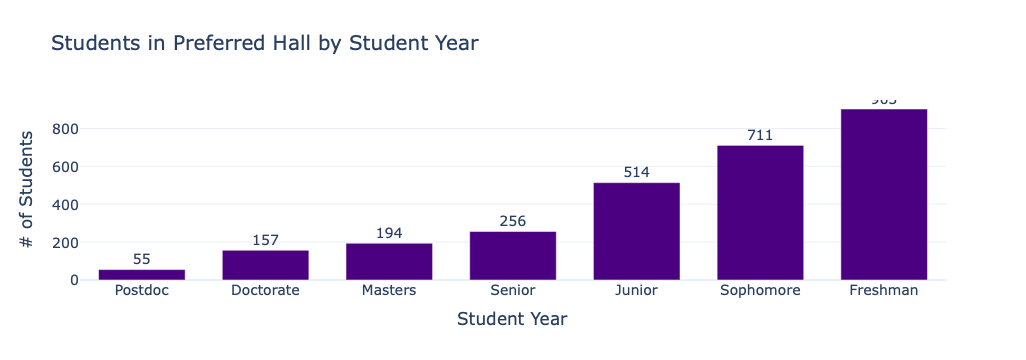

In [60]:
#data and graphs
import plotly.graph_objects as go

levels = [
    "Postdoc", "Doctorate", "Masters", "Senior", "Junior", "Sophomore", "Freshman"
]
values = [
    total_in_preferred_hall_post_doc,
    total_in_preferred_hall_doctorate,
    total_in_preferred_hall_masters,
    total_in_preferred_hall_senior,
    total_in_preferred_hall_junior,
    total_in_preferred_hall_sophomore,
    total_in_preferred_hall_freshman
]

fig = go.Figure(
    data=[
        go.Bar(
            x=levels,
            y=values,
            marker_color="indigo",
            text=values,
            textposition="outside",
        )
    ]
)

fig.update_layout(
    title="Students in Preferred Hall by Student Year",
    xaxis_title="Student Year",
    yaxis_title="# of Students",
    template="plotly_white",
    font=dict(size=14),
    bargap=0.3,
)

fig.show()

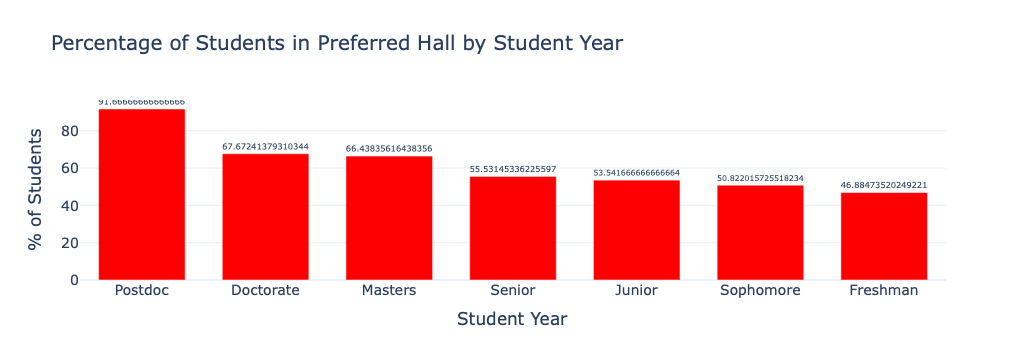

In [61]:
levels = [
    "Postdoc", "Doctorate", "Masters", "Senior", "Junior", "Sophomore", "Freshman"
]
values = [
    total_in_preferred_hall_post_doc / total_post_doc * 100,
    total_in_preferred_hall_doctorate / total_phd * 100,
    total_in_preferred_hall_masters / total_masters * 100,
    total_in_preferred_hall_senior / total_senior * 100,
    total_in_preferred_hall_junior / total_junior * 100,
    total_in_preferred_hall_sophomore / total_sophomore * 100,
    total_in_preferred_hall_freshman / total_freshman * 100
]

fig = go.Figure(
    data=[
        go.Bar(
            x=levels,
            y=values,
            marker_color="red",
            text=values,
            textposition="outside",
        )
    ]
)

fig.update_layout(
    title="Percentage of Students in Preferred Hall by Student Year",
    xaxis_title="Student Year",
    yaxis_title="% of Students",
    template="plotly_white",
    font=dict(size=14),
    bargap=0.3,
)

fig.show()

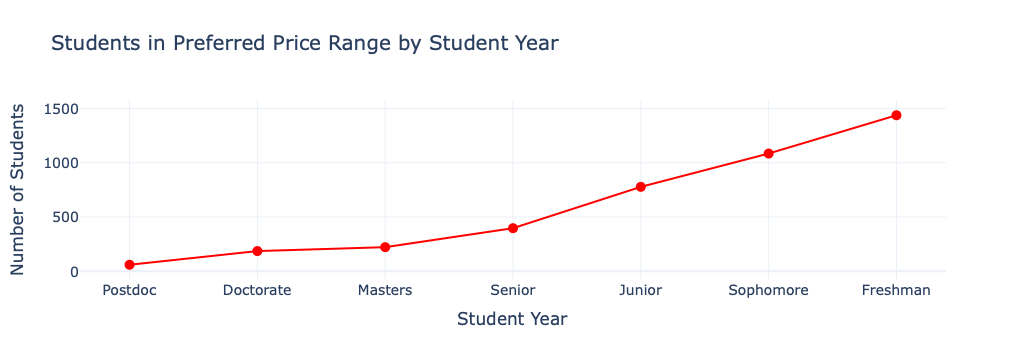

In [65]:
levels = [
    "Postdoc", "Doctorate", "Masters", "Senior", "Junior", "Sophomore", "Freshman"
]

values = [
    total_in_preferred_price_post_doc / total_post_doc * 100,
    total_in_preferred_price_doctorate / total_doctorate * 100,
    total_in_preferred_price_masters / total_masters * 100,
    total_in_preferred_price_senior / total_senior * 100,
    total_in_preferred_price_junior / total_junior * 100,
    total_in_preferred_price_sophomore / total_sophomore,
    total_in_preferred_price_freshman / total_freshman * 100
]

fig = go.Figure(
    data=[
        go.Scatter(
            x=levels,
            y=values,
            mode="markers+lines", 
            marker=dict(size=10, color="red", symbol="circle"),
            line=dict(width=2, color="red"),
            name="Students in Preferred Price Range",
        )
    ]
)

fig.update_layout(
    title="Students in Preferred Price Range by Student Year",
    xaxis_title="Student Year",
    yaxis_title="Number of Students",
    template="plotly_white",
    font=dict(size=14),
)

fig.show()

In [20]:
#send the output to a csv file
import csv
def create_output_file():
    column1_data = []
    column2_data = []
    column3_data = []
    for i in range(len(final_df)):
        current_assignment = final_df.iloc[i]
        if pd.notna(current_assignment.assigned_rooms):
            room = get_room_by_id(current_assignment.assigned_rooms, room_df)
            hall_id = room.hall_id
            building_id = room.building_id
            room_number = room.room_id
            output_list = [hall_id, building_id, room_number]
        else: 
            output_list = float('nan')
        student_id = current_assignment.student_RUID
        column1_data.append(i)
        column2_data.append(student_id)
        column3_data.append(output_list)

    rows = []
    for i in range(len(column1_data)):
        rows.append([column1_data[i], column2_data[i], column3_data[i]])

    outfile = "DatasetA_output.csv"

    with open(outfile, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([" ", "RUID", "Assigned Rooms"])

        writer.writerows(rows)

    print("DONE")
        

create_output_file()

DONE


In [ ]:
#evaluation code goes here


In [ ]:
from collections import deque

#returns a number based on student year
def get_student_year_value(year):
    if year == 'Postdoctoral studies':
        return 1
    elif year == 'Doctorate':
        return 2
    elif year == 'Masters':
        return 3
    elif year == 'Senior':
        return 4
    elif year == 'Junior':
        return 5
    elif year == 'Sophomore':
        return 6
    return 7
    
def deferred_acceptance_algorithm_2(student_df, room_df):
    student_df['assigned_to_room'] = False
    room_df['current_room_occupancy'] = 0
    student_df['room_assignment'] = 'No Room Yet'
    room_df['current_occupants'] = [set() for _ in range(len(room_df))]


    room_assignments = []
    unassigned_students = set(student_df['RUID'])

    count = 0
    for i in range(len(student_df)):
        s = student_df.iloc[i]
        unassigned_students.add(s.RUID)
        if s.accessibility_need == 1:
            count += 1
    print(f"students with accessibility needs: {count}")

    student_df = student_df.sort_values(
        by=['accessibility_need', 'student_year'],
        ascending=[False, True],
        key=lambda s: s.map({
            'Postdoctoral studies': 1, 'Doctorate': 2, 'Masters': 3,
            'Senior': 4, 'Junior': 5, 'Sophomore': 6, 'Freshman': 7
        })
    )
    pass_num = 0
    while unassigned_students:
    #pass #1 to assign all students with accessibility need == 1
        num = 1
        for i in range(len(student_df)):
            student = student_df.iloc[i]
            print(f"Looking at student with assigned to room = {student.assigned_to_room}")
            if student.assigned_to_room == True:
                print(f"skipping student who was already assigned to room")
                continue
            
            if student.accessibility_need == 2:
                print(f"Skipping student {student.RUID}; with accessibility need {student.accessibility_need} :: {num}")
                num += 1
                continue
            
            if pd.notna(student.roommate_after_algorithm):
                #print("adding a pair")
                roommate_id = int(student.roommate_after_algorithm)
                RUID = int(student.RUID)
                result = student_df.loc[student_df['RUID'] == roommate_id].iloc[0]
                rooms = deque(list((set(student.possible_rooms) & set(result.possible_rooms))))
                while rooms:
                    room = rooms.popleft()
                    room_result = room_df.loc[room_df['room_id'] == room[0]].iloc[0]
                    if room_result.current_room_occupancy + 2 <= room_result.max_room_occupancy:
                        room_index = room_df.index[room_df['room_id'] == room[0]].tolist()[0]
                        room_df.at[room_index, 'current_room_occupancy'] += 2
                        result.assigned_to_room = True
                        student_df.at[i, 'assigned_to_room'] = True
                        room_result.current_occupants.add((student.RUID, int(student.roommate_after_algorithm), room[1]))
                        room_result.current_occupants.add((result.RUID, int(result.roommate_after_algorithm), room[1]))
                        unassigned_students.discard(student.RUID)
                        unassigned_students.discard(student.roommate_after_algorithm)
                        #print("assigned a pair")
                        #print(room_result.current_occupants)
                        break
            else:
                rooms = deque(student.possible_rooms)
                while rooms:
                    room = rooms.popleft()
                    room_result = room_df.loc[room_df['room_id'] == room[0]].iloc[0]
                    if room_result.current_room_occupancy + 1 <= room_result.max_room_occupancy:
                        room_index = room_df.index[room_df['room_id'] == room[0]].tolist()[0]
                        room_df.at[room_index, 'current_room_occupancy'] += 1
                        student_df.at[i, 'assigned_to_room'] = True
                        room_result.current_occupants.add((student.RUID, 0, room[1]))
                        student_df.at[i, 'room_assignment'] = room[0]
                        print(f"Student {student.RUID} has been assigned ::: {i} ::: {room_df.at[room_index, 'current_room_occupancy']} ::: {room_result.room_id}")
                        unassigned_students.discard(student.RUID)
                        break
                        #unassigned_students.remove(student.RUID)
                        #print(student_df.at[i, 'room_assignment'])
                        #print(room_result)
                    else: #potentially kick someone out
                        occupants = room_result.current_occupants
                        current_lowest = None
                        for occupant in occupants:
                            if current_lowest == None or occupant[2] < current_lowest[2]:
                                current_lowest = occupant
                        result = student_df.loc[student_df['RUID'] == current_lowest[0]].iloc[0]
                        if current_lowest[1] == 0 and result.student_year == student.student_year:
                            if current_lowest[2] < room[1]:
                                #remove person if score to low
                                occupants.remove(current_lowest)
                                occupants.add((student.RUID, 0, room[1]))
                                unassigned_students.discard(student.RUID)
                                unassigned_students.add(current_lowest[0])
                                room_index = room_df.index[room_df['room_id'] == room[0]].tolist()[0]
                                room_df.at[room_index, 'current_occupants'] = occupants
                                student_df.at[i, 'assigned_to_room'] = True
                                stud_index = student_df.index[student_df['RUID'] == current_lowest[0]].tolist()[0]
                                student_df.at[stud_index, 'assigned_to_room'] = False
                                print(f"Removed {current_lowest} and added {student.RUID}")
                                #print(room)
                                #print(room_df.at[room_index, 'current_occupants'])
                                #return
                        count = 0
                    
            
        print(f"Pass Number: {pass_num} completed\n\n\n")  
        if pass_num > 5:
            return
        pass_num += 1
        
        

deferred_acceptance_algorithm_2(student_df, room_df)

for i in range(len(student_df)):
            student = student_df.iloc[i]
            year = student.student_year
            need = student.accessibility_need
            ruid = student.RUID
            roommate = student.roommate_after_algorithm
            if pd.notna(roommate):
                roommate = int(roommate)
            print(f"Student year: {year}; accessibility need: {need}; RUID: {ruid}; Roommate: {roommate}")
            if i > 100:
                break



In [ ]:
#instead of grabbing a student grap the whole student row from the dataframe (same for a room) that way can 
#just edit directly